<a href="https://colab.research.google.com/github/kevincong95/cs231n-emotiw/blob/master/notebooks/1.0-la-audio-error-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone 'https://github.com/kevincong95/cs231n-emotiw.git'

Cloning into 'cs231n-emotiw'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 702 (delta 7), reused 5 (delta 2), pack-reused 683
Receiving objects: 100% (702/702), 173.73 MiB | 13.32 MiB/s, done.
Resolving deltas: 100% (415/415), done.


In [0]:
# Switch to TF 1.x and navigate to the directory
%tensorflow_version 1.x
!pwd
import os
os.chdir('cs231n-emotiw')
!pwd

# Install required packages 
!pip install -r 'requirements-predictions.txt'

In [0]:
!wget 'https://storage.googleapis.com/cs231n-emotiw/data/Train_labels.txt'
!wget 'https://storage.googleapis.com/cs231n-emotiw/data/Val_labels.txt'
!wget 'https://storage.googleapis.com/cs231n-emotiw/data/train-full.zip'
!wget 'https://storage.googleapis.com/cs231n-emotiw/data/val-full.zip'

In [0]:
!unzip '/content/cs231n-emotiw/val-full.zip'


In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
import os
os.chdir('/content/cs231n-emotiw')

In [3]:
from src.preprocessors.audio_preprocessor import AudioPreprocessor
audio_preprocessor_val = AudioPreprocessor(video_folder='/content/cs231n-emotiw/Val/' , output_folder='val-full-2/' , label_path='./Val_labels.txt')

Using TensorFlow backend.


Video Preprocessor created with video_folder = /content/cs231n-emotiw/Val/ , output_folder = val-full-2/, output_file = None
Frames will be created with hop_size = 0.5


In [0]:
audio_preprocessor_val.preprocess(batch_size=32)

## Retrieve Preprocessed Data

In [0]:
%tensorflow_version 2.x

In [0]:
import numpy as np
X_train = np.load('/content/drive/My Drive/Machine-Learning-Projects/cs231n-project/notebooks/audio-final/audio-pickle-all-X-openl3-train.pkl', allow_pickle=True)
Y_train = np.load('/content/drive/My Drive/Machine-Learning-Projects/cs231n-project/notebooks/audio-final/audio-pickle-all-Y-openl3-train.pkl' , allow_pickle=True)

Y_val = np.load('/content/drive/My Drive/Machine-Learning-Projects/cs231n-project/notebooks/audio-final/audio-pickle-all-Y-openl3-val.pkl' , allow_pickle=True)
X_val = np.load('/content/drive/My Drive/Machine-Learning-Projects/cs231n-project/notebooks/audio-final/audio-pickle-all-X-openl3-val.pkl' , allow_pickle=True)

In [0]:
def normalize(X_train , X_val):
    from sklearn.preprocessing import Normalizer
    X_train_copy = X_train
    X_val_copy = X_val
    scaler = Normalizer()

    for i in range(0,X_train_copy.shape[0]):
      X_train_copy[i] = scaler.fit_transform(X_train_copy[i])

    for i in range(0,X_val_copy.shape[0]):
      X_val_copy[i] = scaler.fit_transform(X_val_copy[i])

    return X_train_copy , X_val_copy

In [0]:
X_train_norm , X_val_norm = normalize(X_train , X_val)

## Retrieve Model and Predict/Evaluate

In [0]:
import tensorflow as tf

In [0]:
!wget 'https://storage.googleapis.com/cs231n-emotiw/models/openl3-cnn-lstm-tuned-lr.h5'

In [0]:
model = tf.keras.models.load_model('/content/cs231n-emotiw/openl3-cnn-lstm-tuned-lr.h5')

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 6144)]      0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          786496    
_________________________________________________________________
batch_normalization (BatchNo (None, None, 64)          256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 512)         66048     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 512)         2048  

In [15]:
print(X_val.shape)

(766, 11, 6144)


## Evaluate Model Performance

In [0]:
predictions = model.predict(X_val_norm)

In [34]:
model.evaluate(X_val , Y_val)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
24/24 [==============================] - 0s 7ms/step - loss: 1.0272 - accuracy: 0.5770


[1.0272266864776611, 0.5770235061645508]

#### F1 Score


In [42]:
from sklearn.metrics import f1_score
y_pred = model.predict(X_val_norm)
Y_class = y_pred.argmax(axis=-1)
f1_score(Y_val, Y_class, average='micro')

0.577023498694517

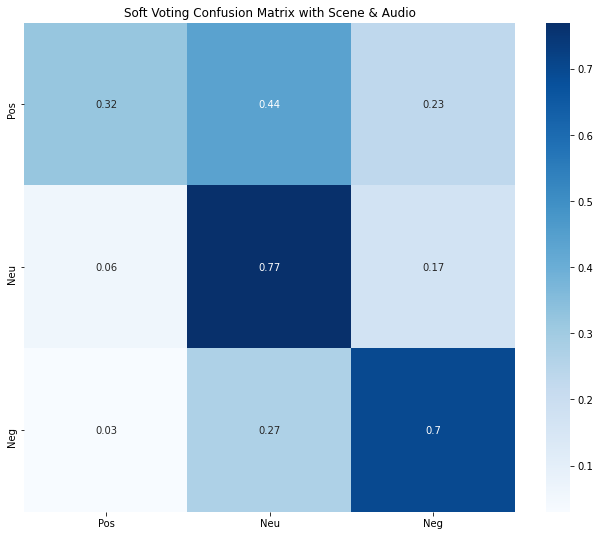

In [48]:
from sklearn import metrics 
import pandas as pd
import seaborn as sn

import matplotlib.pyplot as plt


classes=['Pos' , 'Neu' , 'Neg'] 

con_mat = tf.math.confusion_matrix(labels=Y_val, predictions=Y_class).numpy()

con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                  index = classes, 
                  columns = classes)


figure = plt.figure(figsize=(11, 9))
plt.title("Soft Voting Confusion Matrix with Scene & Audio")
sn.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)

## Visualize some of the Embeddings on a per frame basis

In [0]:
import matplotlib.pyplot as plt
import cv2

class_names = ["Positive" , "Neutral" , "Negative"]
def plot_image(i, time_point, predictions_array, true_label, embeddings):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])


  embed_sqr = np.concatenate([embeddings[i][time_point]]*embeddings.shape[2])
  embed_sqr = cv2.resize(embed_sqr, (28, 28))

  plt.imshow(embed_sqr, cmap=plt.cm.binary)



  predicted_label = np.argmax(predictions_array[i])
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(3))
  plt.yticks([])
  thisplot = plt.bar(range(3), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

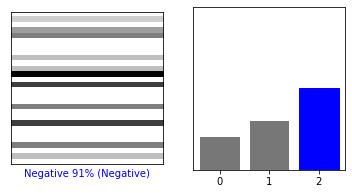

In [51]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i , 1 , predictions, Y_val , X_val)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  Y_val)
plt.show()

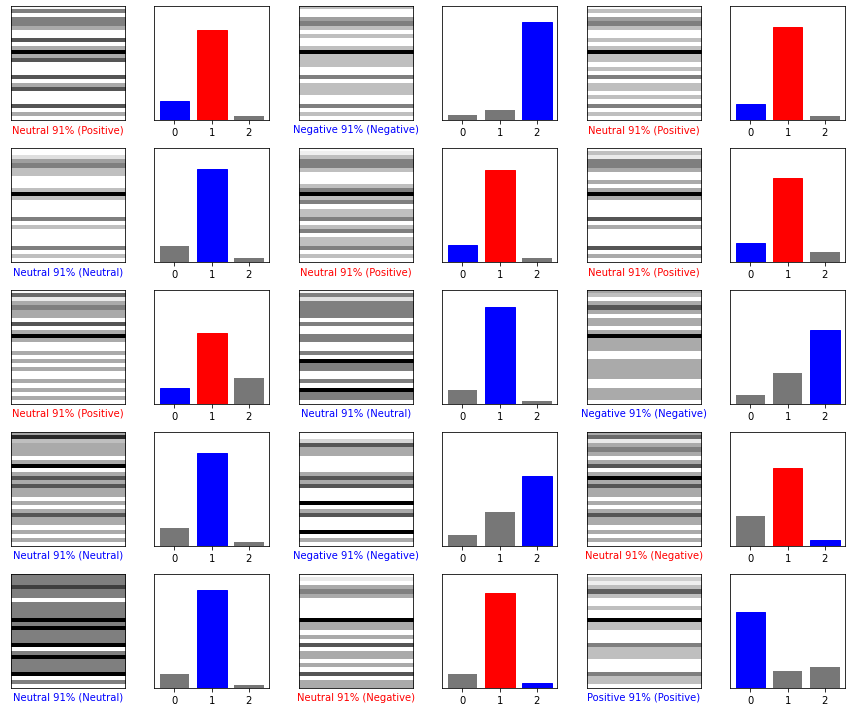

In [54]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3

np.random.seed(42)
np.random.shuffle(X_val)
np.random.shuffle(predictions)
np.random.shuffle(Y_val)

num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i , 1 , predictions, Y_val , X_val)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i],  Y_val)
plt.tight_layout()
plt.show()

## Visualize the input spectrograms and how they affect predictions


In [0]:
# TO DO
def plot_spectrogram(i, audio_file, predictions_array, true_label, embeddings):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])


  embed_sqr = np.concatenate([embeddings[i][time_point]]*embeddings.shape[2])
  embed_sqr = cv2.resize(embed_sqr, (28, 28))

  plt.imshow(embed_sqr, cmap=plt.cm.binary)



  predicted_label = np.argmax(predictions_array[i])
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

In [0]:
classes = ["Positive" , "Neutral" , "Negative"]

def show_batch(all_x, all_y):
    plt.figure(figsize=(30,30))
    for n in range(0,10):
          ax = plt.subplot(5,5,n+1)
          plt.imshow(all_x[n].squeeze(), cmap='gray')
          plt.title(classes[all_y[n] - 1], fontsize=40)
          plt.axis('off')


In [0]:
classes = ["Positive" , "Neutral" , "Negative"]

def show_batch(all_x, all_y):
    plt.figure(figsize=(30,30))
    for n in range(0,10):
          ax = plt.subplot(5,5,n+1)
          plt.imshow(all_x[n].squeeze(), cmap='gray')
          plt.title(classes[all_y[n] - 1], fontsize=40)
          plt.axis('off')

show_batch(X_train_img, y_train)